This notebook adresseses a single machine scheduling problem. The objective studied is minimizing the sum of weighted completion times on a single machine with precedence constraints. 

Each job is associated with:

- proccesing time
- weight


There are precendence relationships which must be satisfied in the schedule. A job can only start its processing after all the predecessor jobs have been completed.

The scheduling problem can be represented by 1|  prec | $\sum\limits_{j=1}^{n}w_𝑗C_j$  . This problem is known to be NP-hard. IBM ILOG CPLEX Optimization Studio includes solvers for both Mathematical and Constraint Programming. Constraint Programming is particularly efficient and useful to tackle detailed scheduling problems. By using docplex.cp python package, you can easily formulate and solve scheduling problems in python notebooks. Below is an example formulation with randomly generated sample data to provide a better understanding of the problem and the model.

In [1]:
nbrOfJobs = 10
jobs = [*range(0, nbrOfJobs)] 

In [2]:
#generate processing time for each job
import random
minProcessingTime=10
maxProcessingTime=40
processingTimes = [random.randint(minProcessingTime, maxProcessingTime) for j in jobs]

In [3]:
#generate weight for each job
minWeight=1
maxWeight=5
weights = [random.randint(minWeight, maxWeight) for j in jobs]

In [4]:
import pandas as pd
JobsTable = pd.DataFrame(columns=['job', 'processing_time', 'weight'])
for j in jobs:
    JobsTable=JobsTable.append({'job': j,'processing_time':processingTimes[j],'weight':weights[j]}, ignore_index=True)
print(JobsTable)

  job processing_time weight
0   0              22      2
1   1              39      3
2   2              11      2
3   3              17      3
4   4              14      2
5   5              24      1
6   6              31      3
7   7              32      3
8   8              18      5
9   9              29      3


In [5]:
#generate precedence relationships 
precedences = list()
for j in jobs:
    if j>=nbrOfJobs/2:
        i = random.randint(0,nbrOfJobs/2-1)
        precedences.append((i, j))  # job i is a predecessor of job j 
print(precedences)

[(2, 5), (4, 6), (4, 7), (3, 8), (2, 9)]


In [6]:
from docplex.cp.model import *
mdl = CpoModel(name='singleMachineSchedulingPrecedence') 

In [7]:
# define production processing interval of each job at each machine
processing_itv_vars = [mdl.interval_var(size=processingTimes[j], name="interval_job{}".format(j)) for j in jobs] 
for j in jobs:
    print(processing_itv_vars[j])

interval_job0 = intervalVar(size=22)
interval_job1 = intervalVar(size=39)
interval_job2 = intervalVar(size=11)
interval_job3 = intervalVar(size=17)
interval_job4 = intervalVar(size=14)
interval_job5 = intervalVar(size=24)
interval_job6 = intervalVar(size=31)
interval_job7 = intervalVar(size=32)
interval_job8 = intervalVar(size=18)
interval_job9 = intervalVar(size=29)


In [8]:
#minimize total weighted completion times
objective = mdl.sum([mdl.end_of(processing_itv_vars[j])*weights[j] for j in jobs])
mdl.add(mdl.minimize(objective)) 

In [9]:
#No overlap constraint
mdl.add(mdl.no_overlap([processing_itv_vars[j] for j in jobs])) 

In [10]:
#Precedences
mdl.add([end_before_start(processing_itv_vars[i],processing_itv_vars[j]) for [i,j] in precedences])

In [11]:
msol= mdl.solve(log_output=True,TimeLimit=30)

In [12]:
print("Solution: ")
msol.print_solution()

Solution: 
-------------------------------------------------------------------------------
Model constraints: 6, variables: integer: 0, interval: 10, sequence: 1
Solve status: Feasible, Fail status: SearchStoppedByLimit
Search status: SearchStopped, stop cause: SearchStoppedByLimit
Solve time: 30.35 sec
-------------------------------------------------------------------------------
Objective values: (2745,), bounds: (1622.98,), gaps: (0.408749,)
interval_job0: (start=152, end=174, size=22, length=22)
interval_job1: (start=174, end=213, size=39, length=39)
interval_job2: (start=35, end=46, size=11, length=11)
interval_job3: (start=0, end=17, size=17, length=17)
interval_job4: (start=46, end=60, size=14, length=14)
interval_job5: (start=213, end=237, size=24, length=24)
interval_job6: (start=89, end=120, size=31, length=31)
interval_job7: (start=120, end=152, size=32, length=32)
interval_job8: (start=17, end=35, size=18, length=18)
interval_job9: (start=60, end=89, size=29, length=29)


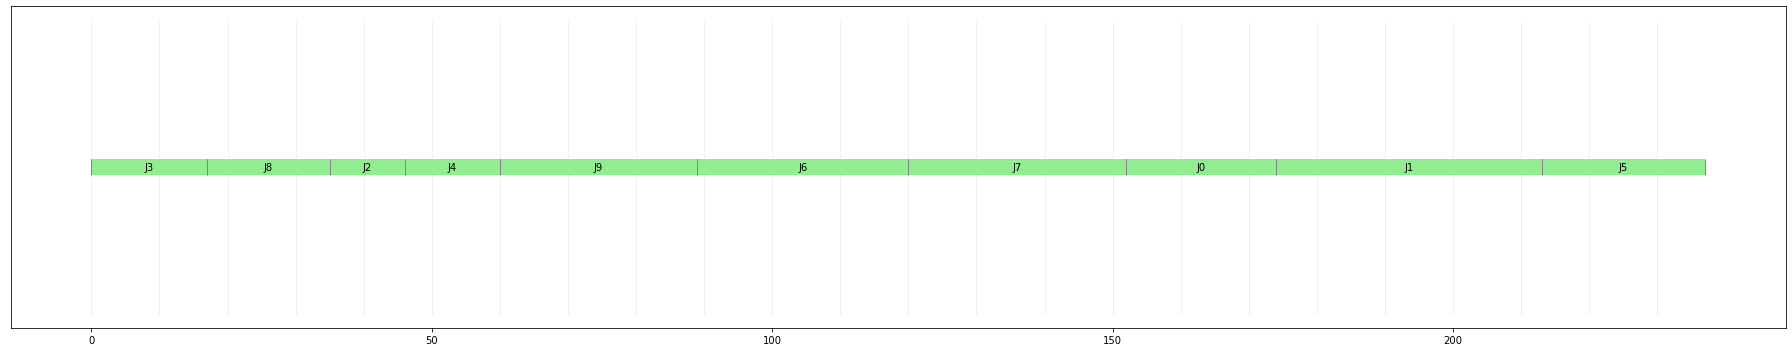

In [13]:
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5
if msol and visu.is_visu_enabled():
    visu.timeline("Solution Schedule", 0, 100)
    for j in jobs:
        itv = msol.get_var_solution(processing_itv_vars[j])
        if itv.is_present():
            visu.interval(itv,'lightgreen','J' + str(j))
    visu.show()